# Gaussian Mixture Models (GMMs)

This notebook will introduce **Gaussian Mixture Models (GMMs)** as a soft clustering method. Compared to K-means, GMMs are more flexible in modeling clusters with elliptical shapes and overlapping boundaries.

We will:

- apply GMMs using `sklearn.mixture.GaussianMixture`
- evaluate clustering performance using the silhouette, AIC, and BIC
- compare GMM results to K-means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

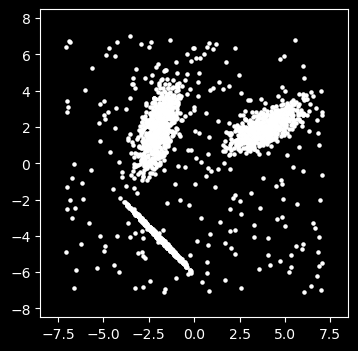

In [54]:
from sklearn.datasets import make_blobs, make_classification

dataset_type = 'classification'

if dataset_type == 'blobs':
    X1, _ = make_blobs(n_samples=2000,
                       centers=3,
                       cluster_std=0.5,
                       random_state=0)
elif dataset_type == 'classification':
    X1, _ = make_classification(n_samples=2000,
                                n_features=2,
                                n_redundant=0,
                                n_clusters_per_class=1,
                                n_classes=3,
                                class_sep=3,
                               # random_state=4
                               )

# Normalize and add uniform noise
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(250, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
MAX = np.max(np.abs(X)) * 1.2

# Plotting
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='w', s=5)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.show()


In [34]:
bins = 20

# Calculate 2D histogram
hist, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=bins)

# Construct arrays for the X-Y edges
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")

%matplotlib qt

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface
surf = ax.plot_surface(xpos, ypos, hist, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Frequency')
ax.set_title('2D Histogram')

# Add color bar
fig.colorbar(surf)

plt.show()

# Gaussian Mixture Model overview

Given $K$ clusters, the probability density function for a data point $x_i$ under a GMM is:

$$
p(x_i) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k)
$$

Where:
- $\pi_k$ is the **mixing weight** for cluster $k$, such that $\sum_{k=1}^{K} \pi_k = 1$
- $\mu_k$ is the **mean vector** of the $k$-th Gaussian
- $\Sigma_k$ is the **covariance matrix** of the $k$-th Gaussian
- $\mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ is the multivariate normal density

## Example of mixing three 1D Gaussians

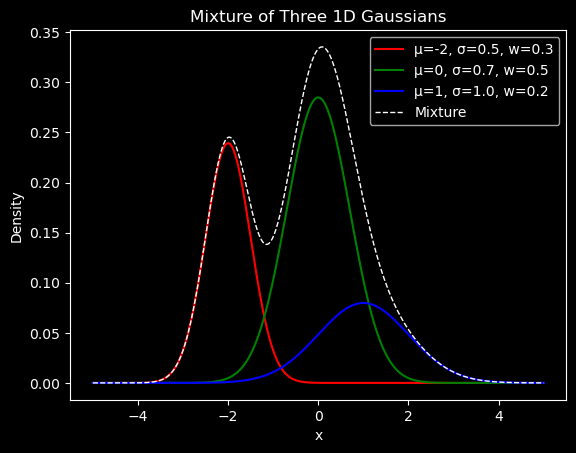

In [5]:
from scipy.stats import norm

# Define x range
x = np.linspace(-5, 5, 1000)

# Define parameters for three Gaussians
params = [
    {"mean": -2, "std": 0.5, "weight": 0.3, "color": "red"},
    {"mean": 0,  "std": 0.7, "weight": 0.5, "color": "green"},
    {"mean": 1,  "std": 1.0, "weight": 0.2, "color": "blue"},
]

# Plot individual Gaussians
mixture = np.zeros_like(x)
for p in params:
    y = p["weight"] * norm.pdf(x, loc=p["mean"], scale=p["std"])
    plt.plot(x, y, color=p["color"], label=f"μ={p['mean']}, σ={p['std']}, w={p['weight']}")
    mixture += y

# Plot the mixture
%matplotlib inline

plt.plot(x, mixture, 'w--', linewidth=1, label='Mixture')
plt.title("Mixture of Three 1D Gaussians")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

## Expectation-Maximization (EM) Algorithm

The GMM parameters are estimated using the **EM algorithm**, which iteratively refines the parameters to maximize the likelihood of the data.

### 1. **E-Step** (Expectation)

Compute the **responsibility** $\gamma_{ik}$, the probability that point $x_i$ belongs to cluster $k$:

$$
\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
$$

### 2. **M-Step** (Maximization)

Update the parameters using the responsibilities:

- Effective number of points in cluster $k$:

  $$
  N_k = \sum_{i=1}^{n} \gamma_{ik}
  $$

- Updated mean:

  $$
  \mu_k = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} x_i
  $$

- Updated covariance:

  $$
  \Sigma_k = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T
  $$

- Updated mixing weight:

  $$
  \pi_k = \frac{N_k}{n}
  $$

Repeat the E and M steps until convergence (typically when the change in log-likelihood is below a threshold).

# Using GMMs w/ sklearn

## Create and fit model

In [1]:
from sklearn.mixture import GaussianMixture

# number of clusters
n_components = 2

# create and fit model
model = GaussianMixture(n_components=n_components)
model.fit(X); # for some reason, fitting GMMs displays a weird message

NameError: name 'X' is not defined

## Predict labels (and probabilities)

In [36]:
labels = model.predict(X)
labels[:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [37]:
probs = model.predict_proba(X)
probs[:10,:]

array([[3.58198101e-10, 1.00000000e+00],
       [1.01838213e-07, 9.99999898e-01],
       [9.99970033e-01, 2.99670833e-05],
       [1.19010801e-05, 9.99988099e-01],
       [1.51961848e-10, 1.00000000e+00],
       [3.12394137e-06, 9.99996876e-01],
       [1.84522917e-08, 9.99999982e-01],
       [4.06333993e-07, 9.99999594e-01],
       [2.17063777e-05, 9.99978294e-01],
       [2.44998610e-05, 9.99975500e-01]])

## Get weights, means, and covariances for each Gaussian component

In [38]:
weights = model.weights_
weights

array([0.33499147, 0.66500853])

In [39]:
means = model.means_
means

array([[-1.90229398, -4.06867213],
       [ 0.95826177,  2.04955332]])

In [40]:
covariances = model.covariances_
covariances

array([[[ 2.48536587, -0.62606414],
        [-0.62606414,  1.21618591]],

       [[11.13606772, -0.03649209],
        [-0.03649209,  1.77586766]]])

## Visualize components

In [13]:
def gaussian_pdf(X, means, covariances):
    
    # Calculate the determinant of the covariance matrix
    cov_det = np.linalg.det(covariances)
    
    # Calculate the inverse of the covariance matrix
    cov_inv = np.linalg.inv(covariances)
    
    # Calculate the difference between X and the mean
    diff = X - means
    
    # Compute the exponent term in the Gaussian PDF
    exponent = -0.5 * np.sum(np.dot(diff, cov_inv) * diff)
    
    # Compute the normalization factor
    normalization = 1 / (2 * np.pi * np.sqrt(cov_det))
    
    # Compute the PDF values
    pdf_values = normalization * np.exp(exponent)
    
    return pdf_values
# end

In [17]:
n_pts = 100

x = np.linspace(-MAX,MAX,n_pts)
y = np.linspace(-MAX,MAX,n_pts)

comps = np.zeros((n_pts,n_pts,n_components))
for i in range(n_components):
    
    for j in range(n_pts):
        for k in range(n_pts):
            comps[k,j,i] = weights[i]*gaussian_pdf(np.array([x[j], y[k]]),
                                                   means[i],
                                                   covariances[i])
        # end
    # end
# end

x, y = np.meshgrid(x,y)

# Create 3D plot
%matplotlib qt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface
ax.plot_wireframe(x, y, comps[:,:,0], color='r', alpha=0.5)
ax.plot_wireframe(x, y, comps[:,:,1], color='g', alpha=0.5)
ax.plot_wireframe(x, y, comps[:,:,2], color='b', alpha=0.5)
#ax.plot_wireframe(x, y, comps[:,:,3], color='m', alpha=0.5)

plt.show()

## Visualize regions

In [18]:
def plot_regions(model):
    
    nGrid = 200
    a1 = np.linspace(-MAX,MAX,nGrid)
    a2 = np.linspace(-MAX,MAX,nGrid)
    
    A1, A2 = np.meshgrid(a1,a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1,A2)).T
    
    B = model.predict(A)
    B = B.reshape(nGrid,nGrid)
    B = np.flipud(B)
    
    return B
# end

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

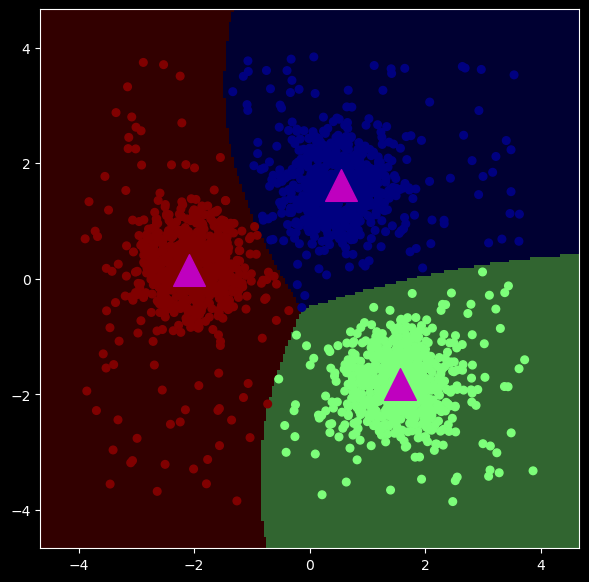

In [21]:
B = plot_regions(model)
extent = [-MAX,MAX,-MAX,MAX]

%matplotlib inline

plt.figure(figsize=(7,7))
plt.imshow(B, interpolation='none', extent=extent,cmap='jet', alpha=0.4)
plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap='jet');
plt.scatter(means[:, 0], means[:, 1], marker='^', s=520, c='m')
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.gca().set_aspect('equal')
plt.show()

# Comparison w/ K-means

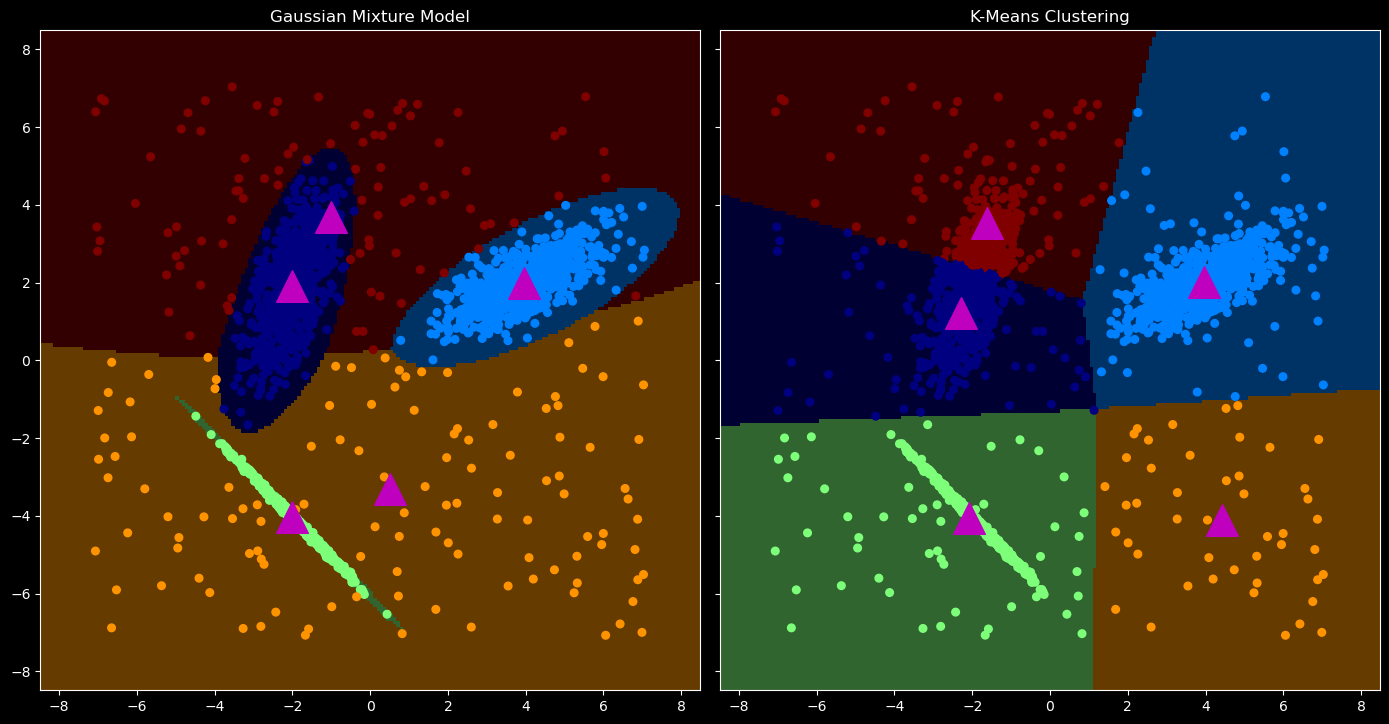

In [55]:
from sklearn.cluster import KMeans

# Set number of clusters/components
k = 5

# ================================
# Fit Gaussian Mixture Model (GMM)
# ================================
gmm_model = GaussianMixture(n_components=k, random_state=0)
gmm_model.fit(X)
labels_gmm = gmm_model.predict(X)
means_gmm = gmm_model.means_

# ================================
# Fit K-Means Model
# ================================
kmeans_model = KMeans(n_clusters=k, n_init="auto", random_state=0)
kmeans_model.fit(X)
labels_kmeans = kmeans_model.predict(X)
means_kmeans = kmeans_model.cluster_centers_

# ================================
# Generate Decision Region Grids
# ================================
B_gmm = plot_regions(gmm_model)
B_kmeans = plot_regions(kmeans_model)

extent = [-MAX, MAX, -MAX, MAX]
cmap = 'jet'

# ================================
# Side-by-Side Plots (GMM on left)
# ================================
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# -- GMM Plot (left) --
axes[0].imshow(B_gmm, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
axes[0].scatter(X[:, 0], X[:, 1], c=labels_gmm, s=30, cmap=cmap)
axes[0].scatter(means_gmm[:, 0], means_gmm[:, 1], marker='^', s=520, c='m')
axes[0].set_title("Gaussian Mixture Model")
axes[0].set_xlim(-MAX, MAX)
axes[0].set_ylim(-MAX, MAX)
axes[0].set_aspect('equal')

# -- K-Means Plot (right) --
axes[1].imshow(B_kmeans, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_kmeans, s=30, cmap=cmap)
axes[1].scatter(means_kmeans[:, 0], means_kmeans[:, 1], marker='^', s=520, c='m')
axes[1].set_title("K-Means Clustering")
axes[1].set_xlim(-MAX, MAX)
axes[1].set_ylim(-MAX, MAX)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [48]:
gmm_model.covariances_

array([[[16.39479577,  0.33063207],
        [ 0.33063207, 15.80919937]],

       [[ 0.66816662, -0.4022252 ],
        [-0.4022252 ,  0.9969229 ]],

       [[ 0.949525  , -0.88517718],
        [-0.88517718,  0.96167191]],

       [[ 1.426771  ,  1.14239978],
        [ 1.14239978,  0.99864993]]])

In [46]:
gmm_model.means_

array([[-0.19387876,  0.15835476],
       [-2.00661245, -4.02737086],
       [-2.01226783,  2.00274309],
       [ 4.05167572,  2.02397533]])

In [47]:
kmeans_model.cluster_centers_

array([[ 3.07905009,  0.67739614],
       [-2.03928632, -4.0478373 ],
       [-2.16623944,  2.13691057],
       [ 4.88459062,  2.94958889]])

# Finding the optimal number of clusters

## Silhouette

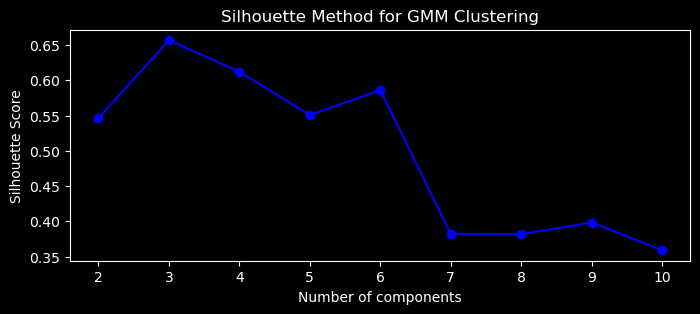

In [31]:
from sklearn.metrics import silhouette_score

# Max number of components to test
k_max = 10

silhouette = []
ks = range(2, k_max + 1)

for k in ks:
    # Fit GMM
    model = GaussianMixture(n_components=k, random_state=0)
    labels = model.fit_predict(X)  # hard assignments
    
    # Compute silhouette score using hard labels
    score = silhouette_score(X, labels)
    silhouette.append(score)

# Plotting the silhouette method graph
plt.figure(figsize=(8, 3))
plt.plot(ks, silhouette, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method for GMM Clustering')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(2, k_max + 1, 1))
plt.show()


## AIC and BIC

When fitting **Gaussian Mixture Models (GMMs)**, we use **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** to select the optimal number of components. Both criteria balance model fit and complexity:

- **AIC**:
  $$
  \text{AIC} = 2k - 2\log L
  $$

- **BIC**:
  $$
  \text{BIC} = \log(n) \cdot k - 2\log L
  $$

Where:
- $k$ is the number of estimated parameters
- $n$ is the number of data points
- $\log L$ is the log-likelihood of the fitted model (see below)

Interpretation:
- **Lower AIC/BIC** values indicate better models.
- **BIC** typically favors simpler models.
- Optimal cluster count corresponds to the **minimum** of the AIC/BIC curve.

The log-likelihood for a GMM with $K$ components is:

$$
\log L = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)
$$

This measures how well the model explains the data:
- Higher $\log L$ means a better fit
- However, $\log L$ always increases with more components, so AIC and BIC penalize complexity to avoid overfitting

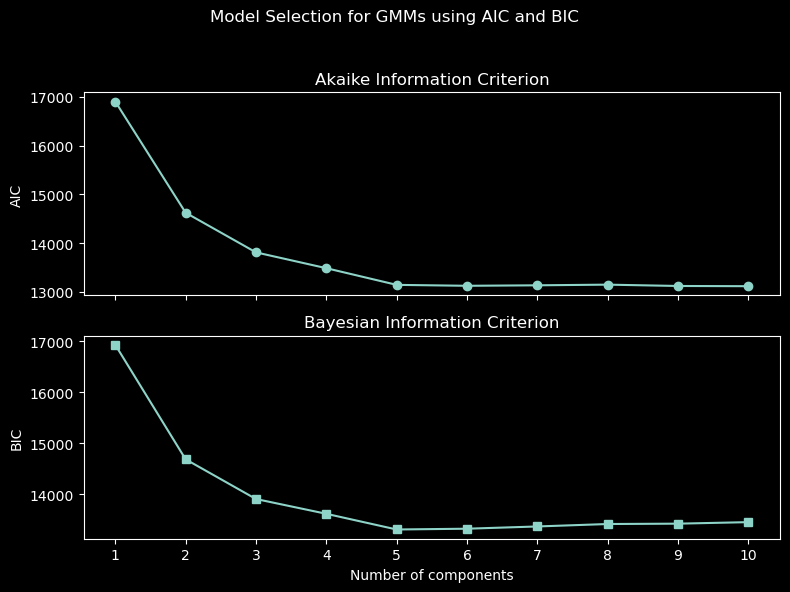

In [32]:
# Max number of components to test
k_max = 10

# Store AIC and BIC scores
aic_scores = []
bic_scores = []

# Fit GMMs for different numbers of components
for k in range(1, k_max + 1):
    model = GaussianMixture(n_components=k, random_state=0)
    model.fit(X)
    aic_scores.append(model.aic(X))
    bic_scores.append(model.bic(X))

# Convert to pandas Series
aic = pd.Series(aic_scores, index=range(1, k_max + 1))
bic = pd.Series(bic_scores, index=range(1, k_max + 1))

# Plot vertical subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

plt.suptitle('Model Selection for GMMs using AIC and BIC')

# AIC subplot
axes[0].plot(aic.index, aic, marker='o', linestyle='-')
axes[0].set_ylabel('AIC')
axes[0].set_title('Akaike Information Criterion')

# BIC subplot
axes[1].plot(bic.index, bic, marker='s', linestyle='-')
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('BIC')
axes[1].set_title('Bayesian Information Criterion')

axes[0].set_xticks(np.arange(1, k_max + 1))
axes[1].set_xticks(np.arange(1, k_max + 1))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()